In [5]:
import torch
import torch.nn as nn
import numpy as np
from BigGAN import Generator
from PIL import Image
import matplotlib.pyplot as plt
from utils import prepare_z_y
from torchvision.utils import save_image
from torchvision.datasets import CIFAR10
import torchvision.models as models
from torch.autograd import Variable
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Resize

In [6]:
class TruncRN(nn.Module):
    def __init__(self):
        super(TruncRN, self).__init__()
        self.model = models.resnet18(pretrained=True).to(device)
        
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        return x

In [7]:
dataset = CIFAR10('.', train=True, transform=Compose([ToTensor()]))
orig = dataset[0][0].view(1, 3, 32, 32)

In [8]:
device = 'cpu'
netG = Generator(n_classes=10, resolution=32, G_shared=False)
netG.load_state_dict(torch.load('G.pth', map_location=torch.device('cpu')), strict=True)

#orig = dataset[0][0].view(1, 3, 64, 64).to(device)
orig_lat, y = prepare_z_y(1, 128, 10, device='cpu')
orig_ = netG(orig_lat, y)
for param in netG.parameters():
    param.requires_grad = False
    
rn = TruncRN().to(device)
for param in rn.parameters():
    param.requires_grad = False
orig = rn(orig_).detach()
    

Param count for Gs initialized parameters: 4303875


In [11]:
z_init = torch.FloatTensor(1, 128).normal_(0, 1).to(device)
z_approx = Variable(z_init.clone())
z_approx.requires_grad = True

optimizer_approx = optim.Adam([z_approx], lr=0.01, betas=(0.5, 0.999))
mse_loss = nn.MSELoss()
losses = []

In [14]:
for i in range(5000):
    g_z_approx = netG(z_approx, y)
    mse_g_z = mse_loss(rn(g_z_approx), orig)
    #mse_g_z = mse_loss(g_z_approx, orig)
    
    optimizer_approx.zero_grad()
    mse_g_z.backward()
    optimizer_approx.step()
    losses.append(mse_g_z.item())
    

KeyboardInterrupt: 

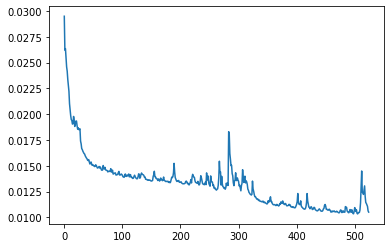

In [15]:
plt.plot(losses)